# <img style="float: left; padding-right: 10px; width: 45px"> GEC AI HUB: Introduction to Data Science and Machine Learning



## Lab 1: Classification and Dimensionality Reduction -- Part 2

**GEC AI Hub**<br>
**Summer 2019**<br>
**Instructors:** Pavlos Protopapas<br>
**Lab Instructors:** Patrick Ohiomoba and Esteban Reyes<br>

---

In [195]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore different models used to predict which of several labels applies to a new datapoint based on labels observed in the training data. We'll similarly explore PCA as a technique for reducing the number of features in a dataset with as little loss of structure as possible.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Logistic Regression
- Be able to make an informed choice of model based on the data at hand
- Be familiar with the SKlearn implementation of Principle Components Analysis (PCA)
- Be able to select an appropriate number of PCA components
- (Bonus) Structure your sklearn code into Pipelines to make building, fitting, and tracking your models easier
- (Bonus) Apply weights to each class in the model to achieve your desired tradeoffs between discovery and false alarm in various classes

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from sklearn.linear_model import LinearRegression, LogisticRegression

from scipy.optimize import minimize

## Part 2:  Alternate Loss Functions

### Generating and Examining our Fake Data

We still need the data we generated in Part 1. Fortunately because we used a `random_state` we can regenerate the same random data set.

In [2]:
fake_X, fake_y = make_classification(n_samples=200, n_features=2, n_informative=1, n_redundant=0, n_clusters_per_class=1, n_classes=2, flip_y=0.1, random_state=3423)

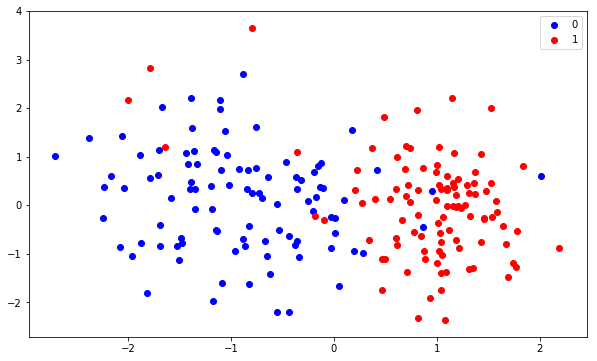

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_X[fake_y == 0][:, 1], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_X[fake_y == 1][:, 1], color='r', label='1')
plt.legend();

Recall that we have two clusters of labeled points: once cluster shwon in red labeled 0 and another cluster shown in blue labeled 1.  Each cluster consists of a set of points in a feature space corresponding to $\mathbb{R}^2$.  From casual inspection it looks like the points are somewhat well separated along the X-axis but not very well separated along the Y-axis.  Let's test this hypothesis.

In [4]:
def sigmoid(x):
    '''Activation function used to map any real value between 0 and 1'''
    return 1 / (1 + np.exp(-x))

def sigmoid_prob(beta, x):
    '''Gives the probability after passing feature vector x through sigmoid of parameters beta'''
    return sigmoid(np.dot(x, beta))

def add_constant(x):
    '''Takes a feature vector x and adds a column of 1s'''
    return np.append(np.ones((x.shape[0],1)), x, axis=1)

In [14]:
data = np.linspace(-3,2,100).reshape(-1, 1)
augmented_data = add_constant(data)

### Solving Logistic Regression Manually with our Fake Data

Recall that we defined a function for cross-entropy loss.

Exercise: Write a function `xent_loss`  that given beta coefficiients `beta`, a dataset `X` and binary labels `y` calculates the cross-entropy loss from using a logistic function with the given beta coefficients to classify the dataset `X`.

In [5]:
def xent_loss(beta, X, y):
    '''Computes the cross entropy loss for samples and labels given in X and y'''
    return -(1 / X.shape[0]) * np.sum(
        y * np.log(sigmoid_prob(beta, X)) + (1 - y) * np.log(
            1 - sigmoid_prob(beta, X)))


Exercise: Write a function `mse_loss`  that given beta coefficients `beta`, a dataset `X` and binary labels `y` calculates the mse loss from using a logistic function with the given beta coefficients to classify the dataset `X`.

In [6]:
def mse_loss(beta, X, y):
    '''Computes the mse loss for samples and labels given in X and y'''
    return np.mean((y-sigmoid_prob(beta, X))**2)
   

Exercise: Write a function `misclass_loss`  that given beta coefficients `beta`, a dataset `X` and binary labels `y` calculates the misclassification loss from using a logistic function with the given beta coefficients to classify the dataset `X`.

In [7]:
def misclass_loss(beta, X, y):
    '''Computes the misclassification loss for samples and labels given in X and y'''
    return np.mean(1*(y == 1*(sigmoid_prob(beta, X) > 0.5)))
   

Now we'll use a lambda function to create a new function `fake_xent_loss`, `fake_mse_loss`, and  that will apply our loss function to our fake dataset we created above.

In [8]:
fake_xent_loss = lambda beta: xent_loss(beta, add_constant(fake_X[:,0].reshape(-1,1)), fake_y)
fake_mse_loss = lambda beta: mse_loss(beta, add_constant(fake_X[:,0].reshape(-1,1)), fake_y)
fake_misclass_loss = lambda beta: misclass_loss(beta, add_constant(fake_X[:,0].reshape(-1,1)), fake_y)

Now let's use the `minimize` function from scipy to find the optimal parameters

In [11]:
opt_fake_xent_params = minimize(fake_xent_loss, [0,0], method="Nelder-Mead").x
opt_fake_mse_params = minimize(fake_mse_loss, [0,0], method="Nelder-Mead").x
opt_fake_misclass_params = minimize(fake_misclass_loss, [0,0], method="Nelder-Mead").x

In [12]:
print("Best MSE Loss params: {}".format(str(opt_fake_mse_params)))
print("Best X-Ent Loss params: {}".format(str(opt_fake_xent_params)))
print("Best Miss-Classification Loss params: {}".format(str(opt_fake_misclass_params)))

Best MSE Loss params: [-1.92541755  8.59515261]
Best X-Ent Loss params: [-0.23773429  2.65751123]
Best Miss-Classification Loss params: [ 0.00011719 -0.00059375]


Exercise: Plot the data overlayed on the logistic function from the manually calculated optimal parameters.  How well does the logistic function fit the data?

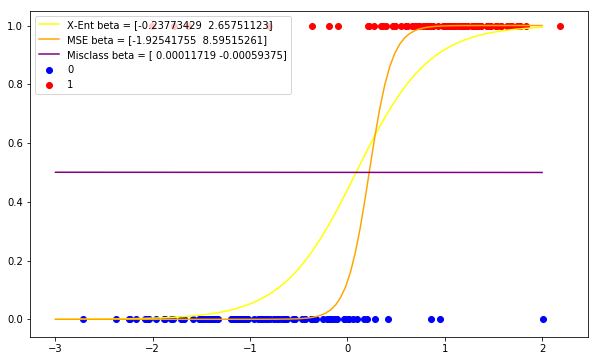

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(opt_fake_xent_params, augmented_data), color='yellow', label="X-Ent beta = " + str(opt_fake_xent_params))
plt.plot(data, sigmoid_prob(opt_fake_mse_params, augmented_data), color='orange', label="MSE beta = " + str(opt_fake_mse_params))
plt.plot(data, sigmoid_prob(opt_fake_misclass_params, augmented_data), color='purple', label="Misclass beta = " + str(opt_fake_misclass_params))
plt.legend();

### Solving Logistic Regression for Heart Data

Let's start by getting the heart data (stored in the Data folder)

In [22]:
heart = pd.read_csv('../Data/heart.csv',)

heart.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,MaxHR,exang,oldpeak,slope,ca,thal,AHD
0,0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [40]:
xrange = np.linspace(80,200,1000).reshape(-1,1)
augmented_xrange = add_constant(xrange)

Exercise: Use sklearn Logistic Regression to model the atherosclerotic heart disease (AHD) based on the Maximum Heat Rate (MaxHR).  Show the  the optimal parameters.  Plot the resulting logistic function overlayed on the data.  How do the parameters from sklearn compare to those from the manual calculation?

In [36]:

from sklearn.linear_model import LogisticRegression

data_x = heart.MaxHR
data_y = heart.AHD

logreg = LogisticRegression(C=10000, fit_intercept=True, solver='lbfgs')
logreg.fit(data_x.values.reshape(-1,1), data_y)

print('Estimated beta1: \n', logreg.coef_)
print('Estimated beta0: \n', logreg.intercept_)

beta_hr = list(logreg.intercept_) + list(logreg.coef_[0])

Estimated beta1: 
 [[-0.03209278]]
Estimated beta0: 
 [3.82605083]


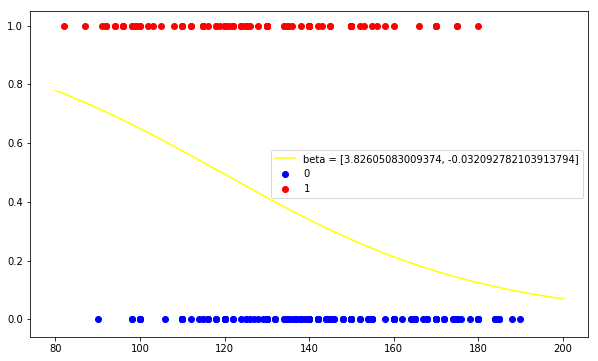

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(data_x[data_y == 0], data_y[data_y == 0], color='b', label='0')
plt.scatter(data_x[data_y == 1], data_y[data_y == 1], color='r', label='1')
plt.plot(xrange, sigmoid_prob(beta_hr, augmented_xrange), color='yellow', label="beta = " + str(beta_hr))
plt.legend();

To complicate things, let's fit a Logistic regresion with two predictors and interprete their parameters. Use MaxHR and sex

In [51]:

from sklearn.linear_model import LogisticRegression

data_x = heart[['MaxHR', 'sex']].values
data_y = heart.AHD

logreg2 = LogisticRegression(C=10000, fit_intercept=True, solver='lbfgs')
logreg2.fit(data_x, data_y)

print('Estimated beta1, beta2: \n', logreg2.coef_)
print('Estimated beta0: \n', logreg2.intercept_)

Estimated beta1, beta2: 
 [[-0.03147952  1.45518253]]
Estimated beta0: 
 [2.60972034]


In [52]:
lr2_opt_params = list(logreg2.intercept_) + list(logreg2.coef_[0])
lr2_opt_params

[2.609720343275758, -0.03147952429903578, 1.4551825312715678]

Let's plot the decision boundary

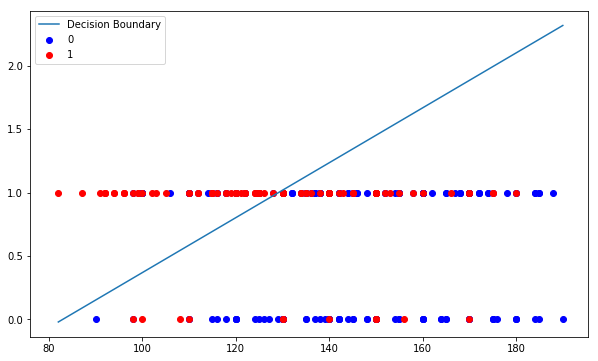

In [53]:
x_values = np.linspace(np.min(data_x[:, 0]), np.max(data_x[:, 0]), 200)
y_values = - (lr2_opt_params[0] + np.dot(lr2_opt_params[1], x_values)) / lr2_opt_params[2]

plt.figure(figsize=(10, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='b', label='0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='r', label='1')
plt.plot(x_values, y_values, label='Decision Boundary')

plt.legend();

**Logistic as Probabilities**

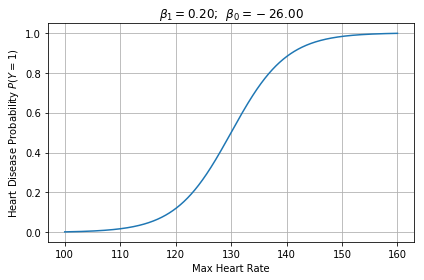

In [54]:
def logR(x, b1, b0):
    return 1/(1+np.exp(-(x*b1+b0)))


def plot_logR(x, b1, b0, print_betas=False):
    output = logR(input,b1,b0)
    #plt.xkcd(scale=0.6, length=0.0)
    plt.plot(input, output)
    if print_betas:
        plt.title(r'$\beta_1=%.2f$;  $\beta_0=%.2f$' % (b1, b0))
    else:
        plt.title(r'$\beta_1=?$;  $\beta_0=?$')
    plt.ylabel(r'Heart Disease Probability $P(Y=1)$')
    plt.xlabel('Max Heart Rate')
    plt.tight_layout()
    plt.grid()
    plt.show()

input= np.linspace(100,160,1000)
b1 = 0.2
output = plot_logR(input,b1,-130*b1, True)

Which estimates the probability of having a Hear Disease, given the MAX Heart Rate of a subject.

Create a function that given a $Max Heart Rate$ value, generate $N$ patientes that are either healthy (0) or have a Heart Disease (1). To do so, you should sample from a bernoulli distribution and extract the parameter that defines that bernoulli distribution from the Logistic Regresion output.

In [55]:
def bernoulli_sampler(MaxHeartRate, N_patients, b1, b0):
    p_bernoulli = output = logR(MaxHeartRate, b1, b0)
    probabilities = np.random.uniform(size=N_patients)
    bernoulli_samples = 1*(probabilities<p_bernoulli)
    return bernoulli_samples

For $Max Heart Rate={100, 120, 130, 150}$ generate a population of 100 patients, for every $Max Heart Rate$

In [56]:
n_patients = 100
print(bernoulli_sampler(100,n_patients,b1,-130*b1))
print(bernoulli_sampler(120,n_patients,b1,-130*b1))
print(bernoulli_sampler(130,n_patients,b1,-130*b1))
print(bernoulli_sampler(150,n_patients,b1,-130*b1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0
 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0
 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


For every population that you previously generated calulate it's probability of choosing a patient with a Heart Disease

In [25]:
print(np.mean(bernoulli_sampler(100,n_patients,b1,-130*b1)))
print(np.mean(bernoulli_sampler(120,n_patients,b1,-130*b1)))
print(np.mean(bernoulli_sampler(130,n_patients,b1,-130*b1)))
print(np.mean(bernoulli_sampler(150,n_patients,b1,-130*b1)))

0.01
0.12
0.52
0.98
